# Agentic RAG

- Retrival Agents are useful when we wanted to make decisions about whether to retrieve from an index
- To implement the retrieval agen, we simplt need to give an LLM access to a retriever tool.
- We can incorporate this into LangGraph.

In [1]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI

In [2]:
! pip install pypdf chromadb

In [3]:
! pip install langgraph

In [4]:
import os
import yaml

# Load the YAML file
def load_api_key(yml_file,key_var):
    with open(yml_file, 'r') as file:
        config = yaml.safe_load(file)  # Safely load the YAML file
        return config.get(key_var)  # Retrieve the 'api_key'

# Usage

os.environ['OPENAI_API_KEY'] =load_api_key('chatgpt_api_credentials.yml', 'openai_key')
os.environ['TAVILY_API_KEY'] =load_api_key('tavily_api_key.yml', 'tavily_key')


In [6]:
file_path = "assests_resource\stanford_cs_229_notes.pdf"

docs = PyPDFLoader(file_path).load_and_split()

len(docs)

227

In [7]:
docs[0:5]

[Document(metadata={'source': 'assests_resource\\stanford_cs_229_notes.pdf', 'page': 0}, page_content='CS229 Lecture Notes\nAndrew Ng and Tengyu Ma\nJune 11, 2023'),
 Document(metadata={'source': 'assests_resource\\stanford_cs_229_notes.pdf', 'page': 1}, page_content='Contents\nI Supervised learning 5\n1 Linear regression 8\n1.1 LMS algorithm . . . . . . . . . . . . . . . . . . . . . . . . . . 9\n1.2 The normal equations . . . . . . . . . . . . . . . . . . . . . . . 13\n1.2.1 Matrix derivatives . . . . . . . . . . . . . . . . . . . . . 13\n1.2.2 Least squares revisited . . . . . . . . . . . . . . . . . . 14\n1.3 Probabilistic interpretation . . . . . . . . . . . . . . . . . . . . 15\n1.4 Locally weighted linear regression (optional reading) . . . . . . 17\n2 Classiﬁcation and logistic regression 20\n2.1 Logistic regression . . . . . . . . . . . . . . . . . . . . . . . . 20\n2.2 Digression: the perceptron learning algorithm . . . . . . . . . 23\n2.3 Multi-class classiﬁcation . . . . . .

In [8]:
vectordb = Chroma.from_documents(
    documents= docs,
    collection_name="rag-chroma",
    embedding= OpenAIEmbeddings(),
    persist_directory='./stanford_embedding_db'
)

retriever = vectordb.as_retriever()

In [9]:
vectordb.persist()

C:\Users\saxen\AppData\Local\Temp\ipykernel_3876\3711397106.py:1: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectordb.persist()


In [10]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    'retrieve_info_from_paper',
    'Search and return information about a paper.'
)

tools = [retriever_tool]

In [10]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

In [11]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [21]:
def agent(state: AgentState):
    messages = state['messages']
    model = ChatOpenAI(temperature =0, streaming=True, model='gpt-4o-mini')

    model = model.bind_tools(tools)
    response = model.invoke(messages)

    return {'messages':[response]}

In [22]:
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

# Graph initialiation
graph = StateGraph(AgentState)

#Nodes
graph.add_node('agent', agent)
retrieve_node = ToolNode([retriever_tool])
graph.add_node('retrieve',retrieve_node)

#Edges
graph.add_edge(START, 'agent')
graph.add_conditional_edges('agent', tools_condition,{'tools':'retrieve',
                                                      END: END})
compiled_graph = graph.compile()

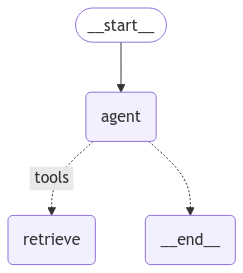

In [23]:
from IPython.display import Image, display


try:
    display(Image(compiled_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # this requires some extra dependencis
    pass 

In [24]:
import pprint
inputs = {
    "messages":[
        ('user','In these notes, can you explain the SVM? ')
    ]
}
for output in compiled_graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint("Output from node '{key}")
        pprint.pprint("---------")
        pprint.pprint(value, indent=2, width=80, depth=None)

    pprint.pprint("\n---\n")

"Output from node '{key}"
'---------'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_mMt8BmVnZsSloka6DrMuWPCm', 'function': {'arguments': '{"query":"Support Vector Machine (SVM)"}', 'name': 'retrieve_info_from_paper'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b'}, id='run-1fb0409d-186e-4822-aa4b-f6ee44076fe9-0', tool_calls=[{'name': 'retrieve_info_from_paper', 'args': {'query': 'Support Vector Machine (SVM)'}, 'id': 'call_mMt8BmVnZsSloka6DrMuWPCm', 'type': 'tool_call'}])]}
'\n---\n'
"Output from node '{key}"
'---------'
{ 'messages': [ ToolMessage(content='Chapter 6\nSupport vector machines\nThis set of notes presents the Support Vector Machine (SVM) learning al-\ngorithm. SVMs are among the best (and many believe are indeed the best)\n“oﬀ-the-shelf” supervised learning algorithms. To tell the SVM story, we’ll\nneed to ﬁrst talk ab

In [25]:
inputs = {
    "messages":[
        ('user','In these notes, can you explain the SVM? ')
    ]
}
output = compiled_graph.invoke(inputs)

output['messages'][-1].content

'Chapter 6\nSupport vector machines\nThis set of notes presents the Support Vector Machine (SVM) learning al-\ngorithm. SVMs are among the best (and many believe are indeed the best)\n“oﬀ-the-shelf” supervised learning algorithms. To tell the SVM story, we’ll\nneed to ﬁrst talk about margins and the idea of separating data with a large\n“gap.” Next, we’ll talk about the optimal margin classiﬁer, which will lead\nus into a digression on Lagrange duality. We’ll also see kernels, which give\na way to apply SVMs eﬃciently in very high dimensional (such as inﬁnite-\ndimensional) feature spaces, and ﬁnally, we’ll close oﬀ the story with the\nSMO algorithm, which gives an eﬃcient implementation of SVMs.\n6.1 Margins: intuition\nWe’ll start our story on SVMs by talking about margins. This section will\ngive the intuitions about margins and about the “conﬁdence” of our predic-\ntions; these ideas will be made formal in Section 6.3.\nConsider logistic regression, where the probability p(y = 1|x;

In [26]:
inputs = {
    "messages":[
        ('user',' Explain gradient descent in detail?')
    ]
}
output = compiled_graph.invoke(inputs)

output['messages'][-1].content

"Gradient descent is an optimization algorithm commonly used in machine learning and statistics to minimize a function by iteratively moving towards the steepest descent as defined by the negative of the gradient. Here’s a detailed explanation of the concept:\n\n### 1. **Objective Function**\nIn machine learning, we often want to minimize a cost function (also known as a loss function) that measures how well our model is performing. The objective function can be represented as \\( J(\\theta) \\), where \\( \\theta \\) represents the parameters of the model.\n\n### 2. **Gradient**\nThe gradient of the function \\( J(\\theta) \\) is a vector of partial derivatives. It points in the direction of the steepest ascent of the function. To minimize the function, we need to move in the opposite direction of the gradient.\n\nMathematically, the gradient is defined as:\n\\[\n\\nabla J(\\theta) = \\left( \\frac{\\partial J}{\\partial \\theta_1}, \\frac{\\partial J}{\\partial \\theta_2}, \\ldots, \